### Table of contents<a class='anchor' id='top'></a>
- [Importing Packages](#1)
- [Importing Data](#2)
- [Selecting a Feature](#3)


# 1. Importing Packages <a class='anchor' id='1'></a> [↑](#top)

In [134]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import random
from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

from scipy import stats

Define some plotting functions

In [135]:

def plot_data(data,colname = "test"):
    plt.figure(figsize=(8, 4))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
    plt.title(colname)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

def plot_time_series(dataframe,col="test"):
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe[col], marker='')
    plt.title(col)
    plt.ylim(17,20)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

# 3. Importing Data <a class='anchor' id='3'></a> [↑](#top)

In [76]:
real_dataset = pd.read_csv("real_dataset.csv",index_col = 0)
real_dataset.head()

,Stage1.Output.Measurement9.U.Actual
330,17.95
331,17.95
332,17.95
333,18.09
334,18.09


# 4. Analyse Seasonality <a class='anchor' id='4'></a> [↑](#top)

In order to generate the synthetic data we want to isolate the trend and seasonaliy component from the residuals of the time series. Since we do not know of any inherent seasonaliy in the dats we find the seasonality, which maximizes the residuals.

In [28]:
def get_msr(result):
    return sum((result.resid.dropna())**2)/len(real_dataset.iloc[:,0])


In [29]:

periods = [10*(x+1) for x in range(600)]
msrs = []

for i in periods:
     result = seasonal_decompose(real_dataset.iloc[:,0], model='additive',period=i)
     msrs.append(get_msr(result))


We find the value that maximizes the residuals is a seasonality of 850

In [32]:
periods[np.argmax(msrs)]

850

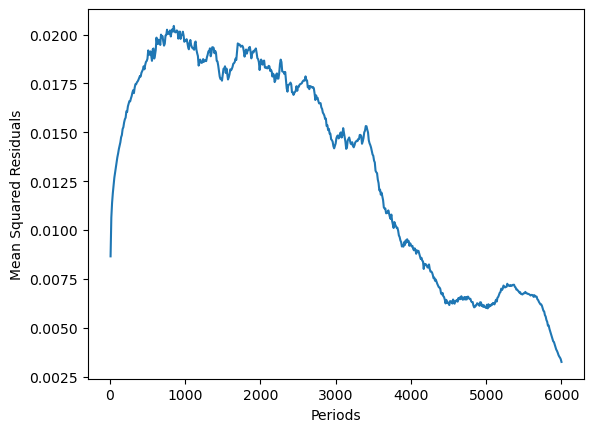

In [30]:
plt.plot(periods,msrs)
plt.xlabel("Periods")
plt.ylabel("Mean Squared Residuals")
plt.show()

This leads to the following decomposition.

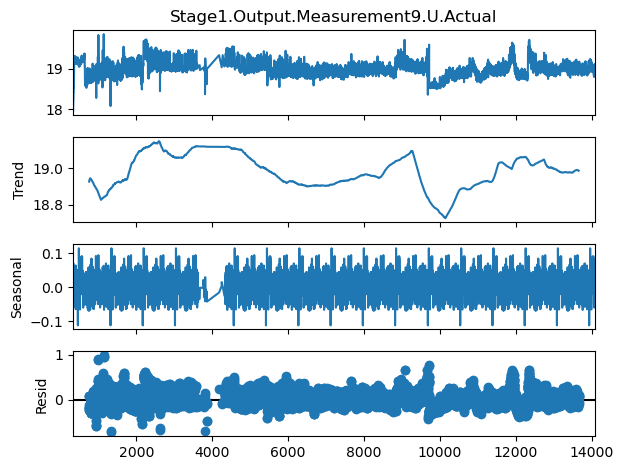

In [31]:
sd = seasonal_decompose(real_dataset.iloc[:,0], model='additive',period=850)
sd.plot()
plt.show()

In [109]:
times_series_decomposition = pd.DataFrame(sd.resid)
times_series_decomposition.insert(0, "seasonal",sd.seasonal)
times_series_decomposition.insert(0, "trend",sd.trend)

(times_series_decomposition)


,trend,seasonal,resid
330,NaN,0.027700,NaN
331,NaN,0.029834,NaN
332,NaN,0.023395,NaN
333,NaN,0.009095,NaN
334,NaN,0.016224,NaN
...,...,...,...
14083,NaN,-0.017654,NaN
14084,NaN,-0.027666,NaN
14085,NaN,0.011597,NaN
14086,NaN,0.018712,NaN


# 5. Generate Synthetic Residuals <a class='anchor' id='5'></a> [↑](#top) 
In order to combine the real dataset with our synthetic data. Our goal is to sample synthetic residuals from certain distributions. Therefore we generate characteristic data with a given shape and map the domain to match the range of the real residuals.

In [82]:
mean = real_dataset.mean()
std =real_dataset.std()
min = real_dataset.min()
max = real_dataset.max()
real_dataset = np.array(real_dataset).reshape(1,-1)[0]

length = len(real_dataset)



Since we rescale the data according to our residuals, the parameters are "almost" arbitrary.

In [83]:
rng = np.random.default_rng() 
exponential_dataset = np.random.exponential(std,length)
gamma_dataset = np.random.gamma(mean,std,length)
pareto_dataset = np.random.pareto(20,length)
power_dataset = np.random.power(std,length)
gumbel_dataset = np.random.gumbel(mean,std,length)
laplace_dataset = np.random.laplace(mean,std,length)
logistic_dataset = np.random.logistic(mean,std,length)
lognormal_dataset = np.random.lognormal(mean,std,length)

bimodal_lognormal_dataset1 = np.random.lognormal(mean-0.7,std,int(length/2))
bimodal_lognormal_dataset2 = np.random.lognormal(mean+0.7,std,int(length/2))
bimodal_lognormal_dataset = np.concatenate([bimodal_lognormal_dataset1,bimodal_lognormal_dataset2])
rng.shuffle(bimodal_lognormal_dataset)

rayleigh_dataset = np.random.rayleigh(std,length)
vonmises_dataset = np.random.vonmises(mean,std,length)
triangular_dataset = np.random.triangular(min,mean,max,length)
uniform_dataset = np.random.uniform(min,max,length)
wald_dataset = np.random.wald(mean,200,length)
weibull_dataset = np.random.weibull(1.5,length)

normal_dataset = np.random.normal(mean,std,length)


bimodal_normal_symmetric_dataset1 = np.random.normal(mean-0.7,std,int(length/2))
bimodal_normal_symmetric_dataset2 = np.random.normal(mean+0.7,std,int(length/2))
bimodal_normal_symmetric_dataset = np.concatenate([bimodal_normal_symmetric_dataset1, bimodal_normal_symmetric_dataset2])
rng.shuffle(bimodal_normal_symmetric_dataset)

bimodal_normal_asymmetric_dataset1 = np.random.normal(mean-0.7,std,int(length/3))
bimodal_normal_asymmetric_dataset2 = np.random.normal(mean+0.7,std, 1+ int(2* (length/3)))
bimodal_normal_asymmetric_dataset = np.concatenate([bimodal_normal_asymmetric_dataset1, bimodal_normal_asymmetric_dataset2])
rng.shuffle(bimodal_normal_asymmetric_dataset)

datasets = [real_dataset,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,
            laplace_dataset,logistic_dataset,lognormal_dataset,bimodal_lognormal_dataset,
            rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,
            weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset,
            ]
datasets_names = [
    "real_dataset",
    "exponential_dataset",
    "gamma_dataset",
    "pareto_dataset",
    "power_dataset",
    "gumbel_dataset",
    "laplace_dataset",
    "logistic_dataset",
    "lognormal_dataset",
    "bimodal_lognormal_dataset",
    "rayleigh_dataset",
    "vonmises_dataset",
    "triangular_dataset",
    "uniform_dataset",
    "wald_dataset",
    "weibull_dataset",
    "normal_dataset",
    "bimodal_normal_symmetric_dataset",
    "bimodal_normal_asymmetric_dataset"
]

In [92]:
residuals = times_series_decomposition["resid"]
residuals = residuals.dropna()
min = residuals.min()
max = residuals.max()

In [93]:
##Define Functions for the normalization of the Datasets
def min_max_norm(data):
    data = (data - data.min())/(data.max()-data.min())
    return data

def retransform(data,min = min,max = max):
    data = data * (max-min) + min
    return data

def rescale(data):
    return retransform(min_max_norm(data))

In [96]:
normalized_datasets = np.array([rescale(x) for x in datasets[1:]])
dataframe = pd.DataFrame(normalized_datasets.T)
dataframe.columns = datasets_names[1:]
#dataframe.insert(0,"time_stamp", time_array)
dataframe.head()

,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,laplace_dataset,logistic_dataset,lognormal_dataset,bimodal_lognormal_dataset,rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset
0,-0.542930,-0.082771,-0.463172,-0.531826,-0.162874,0.293543,0.410565,-0.132924,-0.014638,0.054648,-0.619769,-0.636347,-0.286126,-0.480715,-0.185379,0.183278,-0.469458,-0.476732
1,-0.678609,-0.073871,-0.615810,-0.733540,-0.235304,0.246937,0.322174,-0.517330,-0.616487,-0.076910,0.295260,0.133888,-0.000634,-0.592711,-0.696703,-0.005562,0.689964,0.316144
2,-0.338129,-0.369890,-0.680935,-0.682265,-0.169236,0.247813,0.137640,0.099085,0.241262,0.339330,-0.587738,0.214324,0.138728,-0.158109,-0.456217,0.169425,-0.489101,0.403673
3,-0.583856,-0.332740,-0.544148,0.619542,-0.391268,0.231699,0.170671,-0.502268,-0.659530,-0.261682,0.525596,0.392210,0.119446,-0.378589,-0.719231,-0.044882,0.547904,-0.326941
4,-0.733350,-0.071651,-0.724154,-0.699395,0.109518,0.203610,-0.054792,-0.276058,-0.584865,-0.243977,0.270465,-0.492877,0.371694,-0.351000,-0.367602,0.145835,-0.194884,0.515846


The following gives a visualization of all the residuals we generated.

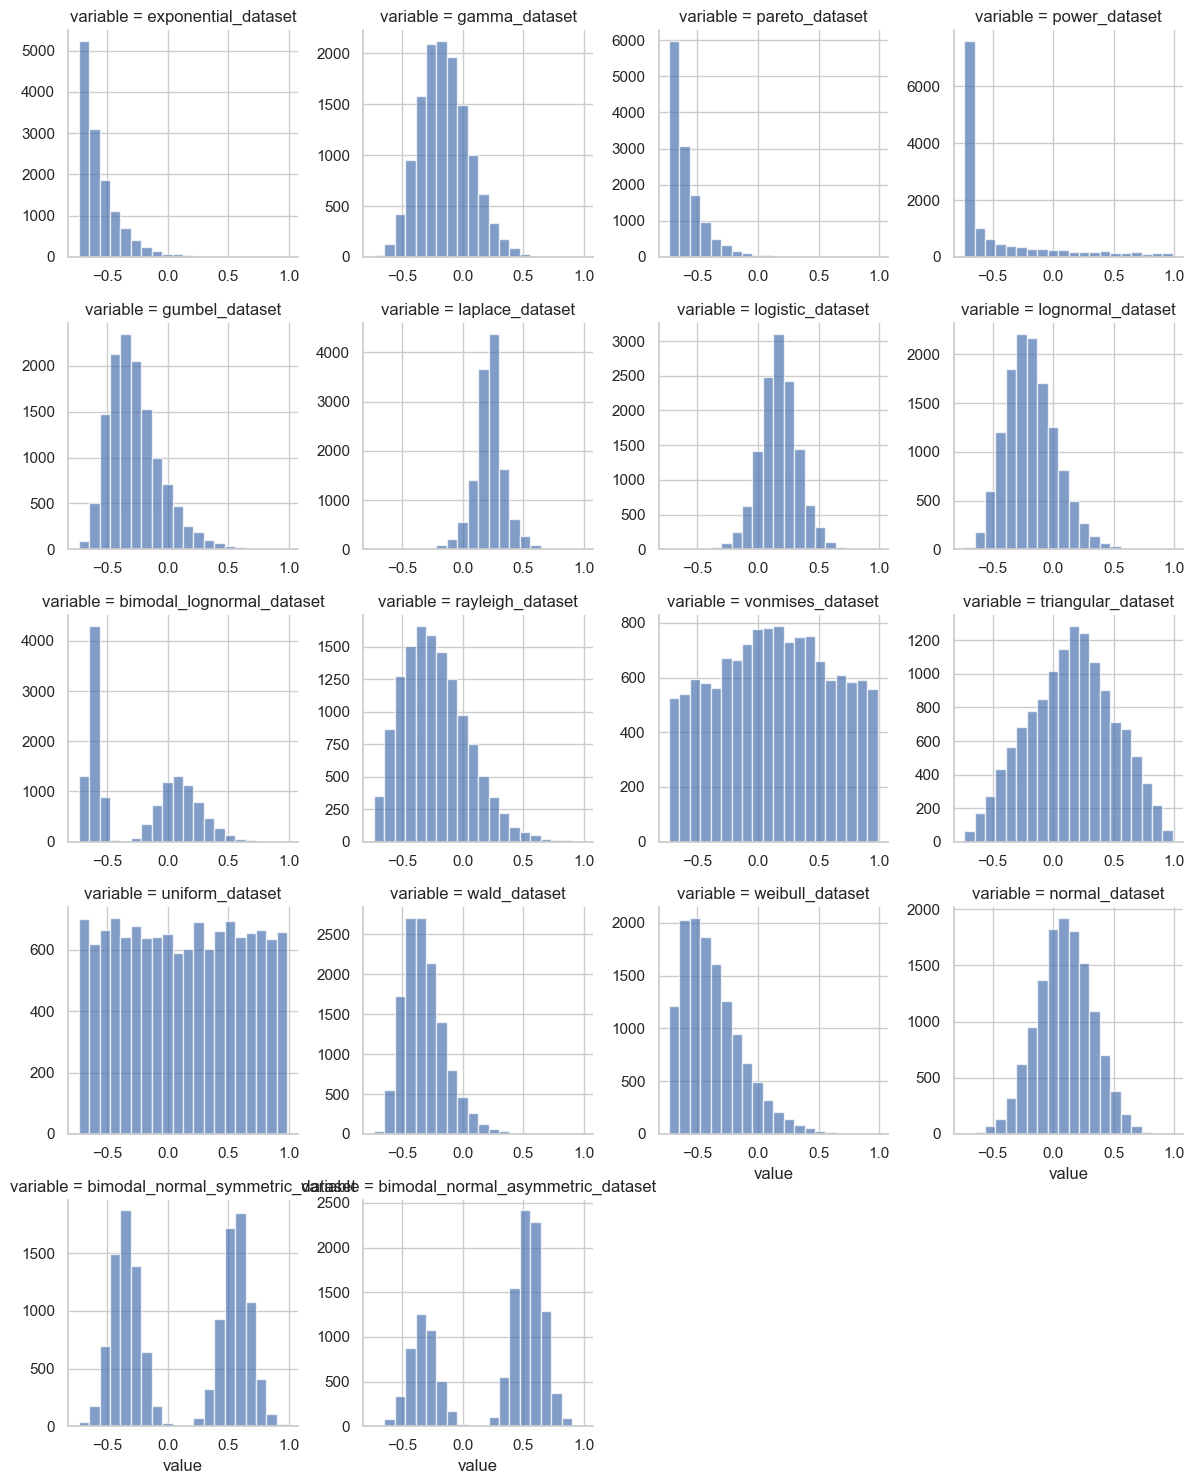

In [104]:
import seaborn as sns
sns.set(style="whitegrid")
grid = sns.FacetGrid(pd.melt(dataframe, value_vars=df.columns), col="variable", col_wrap=4, sharex=False, sharey=False)
grid.map(plt.hist, "value", bins=20, alpha=0.7)
grid.fig.tight_layout(w_pad=1)
plt.show()

# 6. Combine Synthetic Residuals with Trend and Seasonality <a class='anchor' id='6'></a> [↑](#top) 

In [129]:
times_series_decomposition = times_series_decomposition.dropna().reset_index().iloc[:,2:]
times_series_decomposition

,trend,seasonal,resid
0,18.926542,-0.022881,-0.163661
1,18.927683,-0.066294,-0.121389
2,18.928825,-0.057709,-0.191116
3,18.929889,-0.050446,-0.199443
4,18.930877,-0.039839,-0.231038
...,...,...,...
12173,18.987313,-0.020639,-0.056674
12174,18.987289,-0.007280,0.069990
12175,18.987266,0.006080,0.056654
12176,18.987072,-0.017889,0.090817


In [130]:
time_series_residuals = pd.concat([times_series_decomposition,dataframe],axis = 1)
time_series_residuals.dropna()

,trend,seasonal,resid,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,laplace_dataset,logistic_dataset,...,bimodal_lognormal_dataset,rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset
0,18.926542,-0.022881,-0.163661,-0.542930,-0.082771,-0.463172,-0.531826,-0.162874,0.293543,0.410565,...,-0.014638,0.054648,-0.619769,-0.636347,-0.286126,-0.480715,-0.185379,0.183278,-0.469458,-0.476732
1,18.927683,-0.066294,-0.121389,-0.678609,-0.073871,-0.615810,-0.733540,-0.235304,0.246937,0.322174,...,-0.616487,-0.076910,0.295260,0.133888,-0.000634,-0.592711,-0.696703,-0.005562,0.689964,0.316144
2,18.928825,-0.057709,-0.191116,-0.338129,-0.369890,-0.680935,-0.682265,-0.169236,0.247813,0.137640,...,0.241262,0.339330,-0.587738,0.214324,0.138728,-0.158109,-0.456217,0.169425,-0.489101,0.403673
3,18.929889,-0.050446,-0.199443,-0.583856,-0.332740,-0.544148,0.619542,-0.391268,0.231699,0.170671,...,-0.659530,-0.261682,0.525596,0.392210,0.119446,-0.378589,-0.719231,-0.044882,0.547904,-0.326941
4,18.930877,-0.039839,-0.231038,-0.733350,-0.071651,-0.724154,-0.699395,0.109518,0.203610,-0.054792,...,-0.584865,-0.243977,0.270465,-0.492877,0.371694,-0.351000,-0.367602,0.145835,-0.194884,0.515846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12173,18.987313,-0.020639,-0.056674,-0.712191,-0.001489,-0.660431,0.201720,-0.156926,-0.064278,0.284713,...,-0.613434,-0.504694,-0.121064,0.477876,-0.648485,-0.186219,-0.466318,-0.192537,-0.239265,0.489103
12174,18.987289,-0.007280,0.069990,-0.725727,-0.281568,-0.620111,-0.727426,-0.388023,0.250544,0.601715,...,0.498843,-0.726150,-0.224701,0.101611,-0.339550,-0.245563,0.010226,-0.027181,-0.156464,-0.441246
12175,18.987266,0.006080,0.056654,-0.656714,-0.225725,-0.586214,0.735873,-0.343041,0.147727,0.197459,...,-0.568176,-0.395714,-0.105763,-0.323802,-0.287407,-0.333061,-0.555458,0.166637,0.523154,-0.317335
12176,18.987072,-0.017889,0.090817,-0.651955,-0.153840,-0.699166,-0.726908,-0.439396,0.132095,0.157188,...,-0.562038,-0.422306,0.004448,-0.005676,0.508787,-0.436352,-0.293405,0.152296,0.476663,-0.410550


In [131]:
time_series_data = time_series_residuals.iloc[:,2:].apply(lambda x: x + time_series_residuals["trend"]+ time_series_residuals["seasonal"]).dropna()
time_series_data = time_series_data.set_index(np.array(range(0,time_series_data.iloc[:,1].shape[0])),append = False)
time_series_data = pd.concat([ pd.Series(np.array(range(0,time_series_data.iloc[:,1].shape[0]))),time_series_data],axis = 1)
time_series_data = time_series_data.rename(columns={"resid": "real_dataset", 0 : "time_col"})
time_series_data.iloc[:,0:]

,time_col,real_dataset,exponential_dataset,gamma_dataset,pareto_dataset,power_dataset,gumbel_dataset,laplace_dataset,logistic_dataset,lognormal_dataset,bimodal_lognormal_dataset,rayleigh_dataset,vonmises_dataset,triangular_dataset,uniform_dataset,wald_dataset,weibull_dataset,normal_dataset,bimodal_normal_symmetric_dataset,bimodal_normal_asymmetric_dataset
0,0,18.74,18.360731,18.820890,18.440489,18.371835,18.740787,19.197204,19.314226,18.770737,18.889023,18.958309,18.283892,18.267314,18.617535,18.422946,18.718282,19.086939,18.434203,18.426929
1,1,18.74,18.182780,18.787518,18.245579,18.127849,18.626086,19.108327,19.183563,18.344059,18.244902,18.784479,19.156649,18.995277,18.860755,18.268678,18.164686,18.855827,19.551354,19.177533
2,2,18.68,18.532987,18.501225,18.190180,18.188851,18.701880,19.118929,19.008755,18.970201,19.112378,19.210445,18.283378,19.085440,19.009843,18.713006,18.414899,19.040540,18.382014,19.274789
3,3,18.68,18.295587,18.546703,18.335295,19.498985,18.488175,19.111142,19.050114,18.377175,18.219913,18.617761,19.405039,19.271652,18.998889,18.500854,18.160212,18.834561,19.427347,18.552502
4,4,18.66,18.157688,18.819387,18.166884,18.191643,19.000556,19.094649,18.836246,18.614981,18.306173,18.647061,19.161503,18.398162,19.262733,18.540038,18.523437,19.036873,18.696154,19.406884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12173,12173,18.91,18.254482,18.965184,18.306243,19.168394,18.809748,18.902396,19.251387,18.774779,18.353240,18.461980,18.845610,19.444550,18.318189,18.780455,18.500356,18.774137,18.727409,19.455777
12174,12174,19.05,18.254283,18.698442,18.359898,18.252584,18.591986,19.230554,19.581724,18.844487,19.478853,18.253860,18.755309,19.081621,18.640460,18.734447,18.990236,18.952829,18.823546,18.538764
12175,12175,19.05,18.336632,18.767621,18.407133,19.729219,18.650305,19.141073,19.190805,18.822529,18.425170,18.597632,18.887584,18.669544,18.705939,18.660285,18.437889,19.159983,19.516500,18.676011
12176,12176,19.06,18.317227,18.815342,18.270017,18.242275,18.529787,19.101278,19.126371,18.374602,18.407145,18.546876,18.973631,18.963506,19.477970,18.532831,18.675777,19.121479,19.445846,18.558633


Now we can see the clear structure from the sampled distributions, while keeping the integrity of the seasonality and trend of the underlying time series.

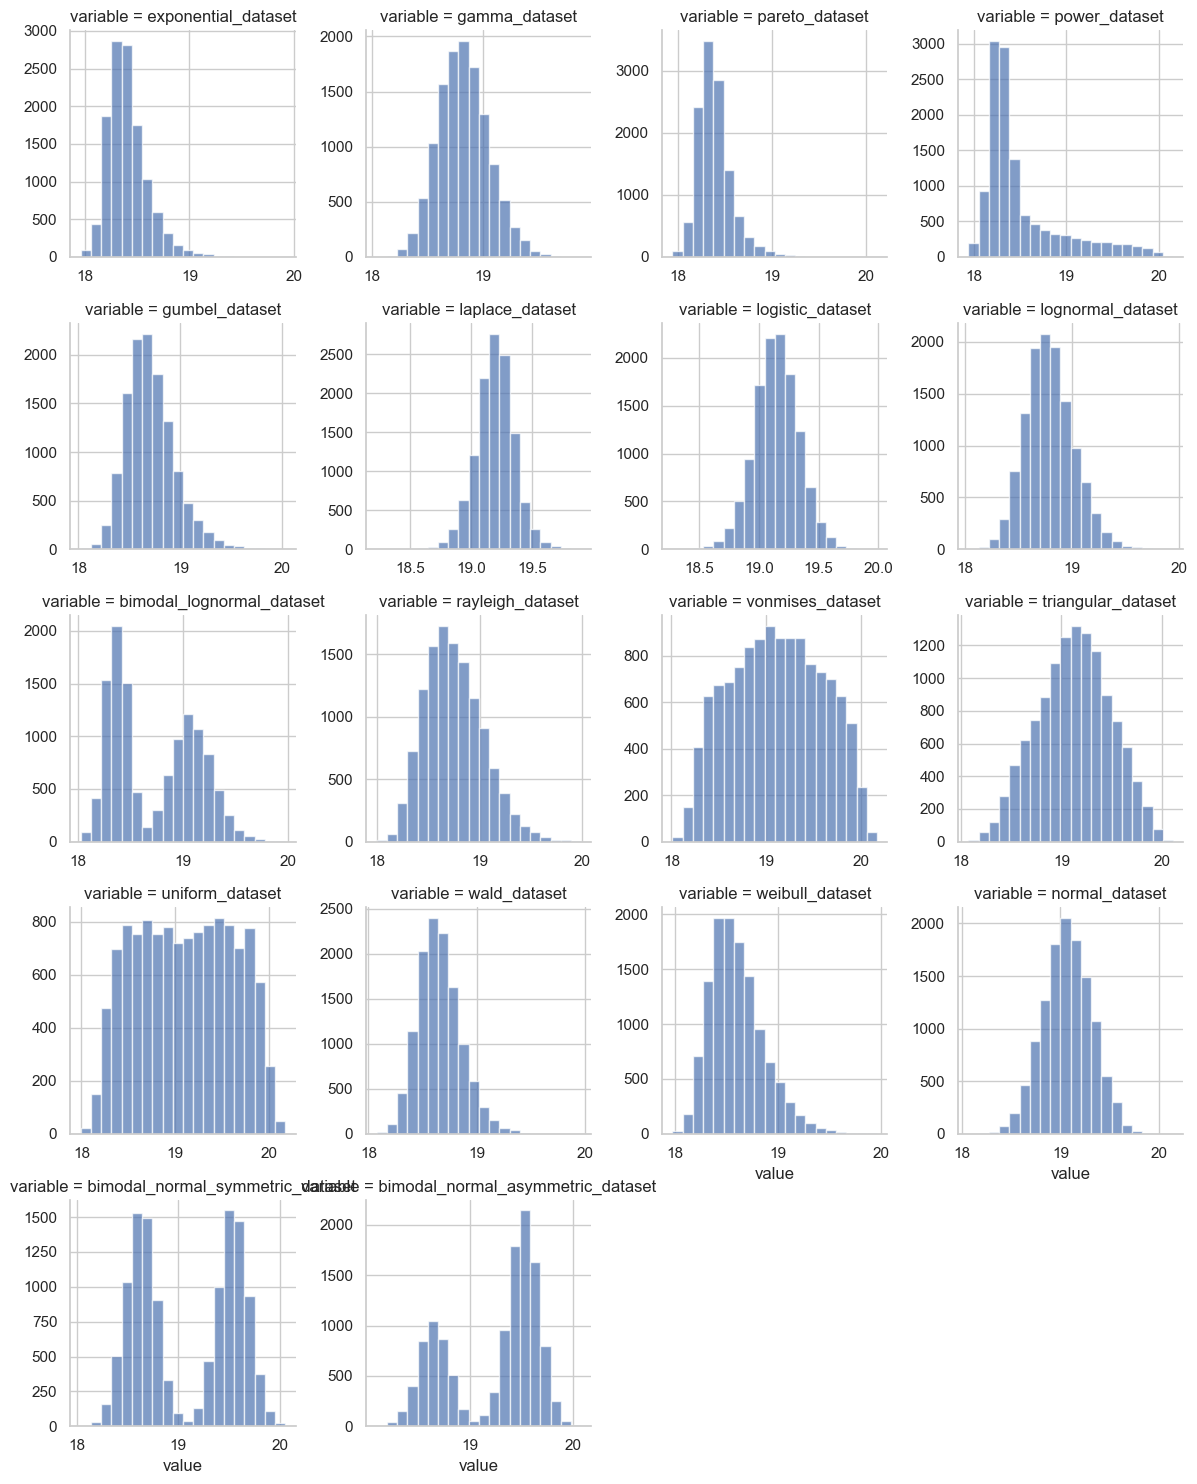

In [133]:
sns.set(style="whitegrid")
grid = sns.FacetGrid(pd.melt(time_series_data.iloc[:,2:], value_vars=df.columns), col="variable", col_wrap=4, sharex=False, sharey=False)
grid.map(plt.hist, "value", bins=20, alpha=0.7)
grid.fig.tight_layout(w_pad=1)
plt.show()

Optionally write data to csv

In [42]:
#time_series_data.to_csv("data_final")

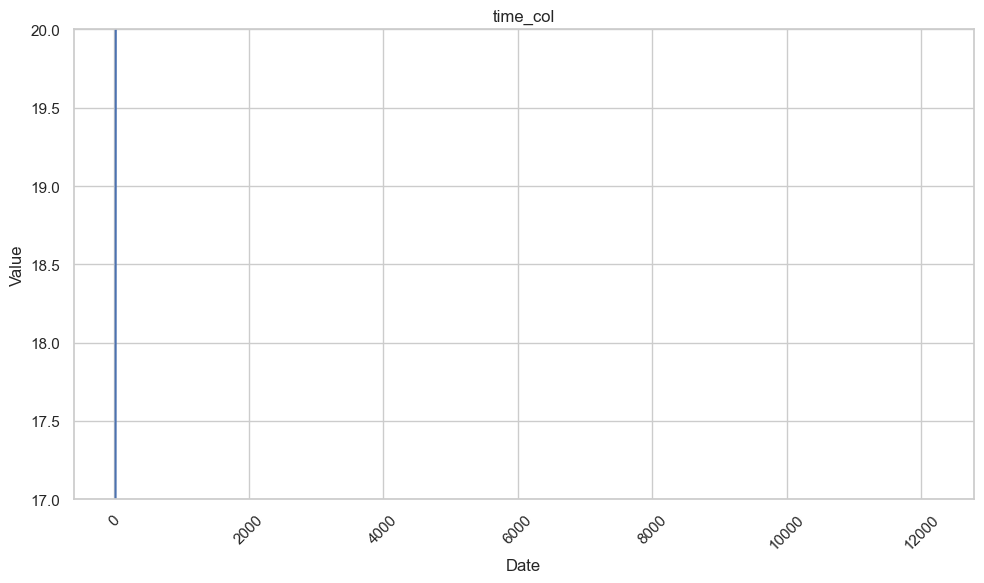

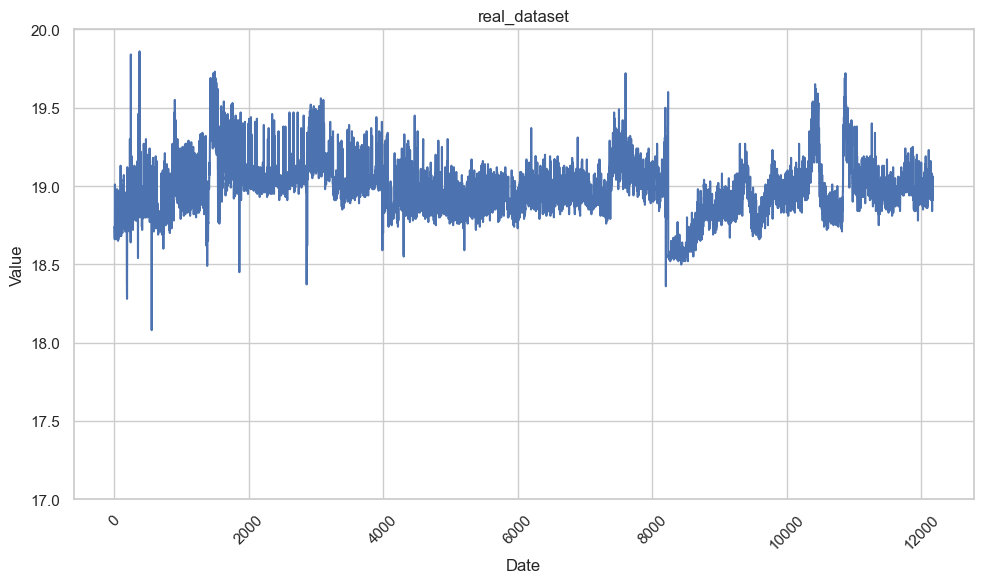

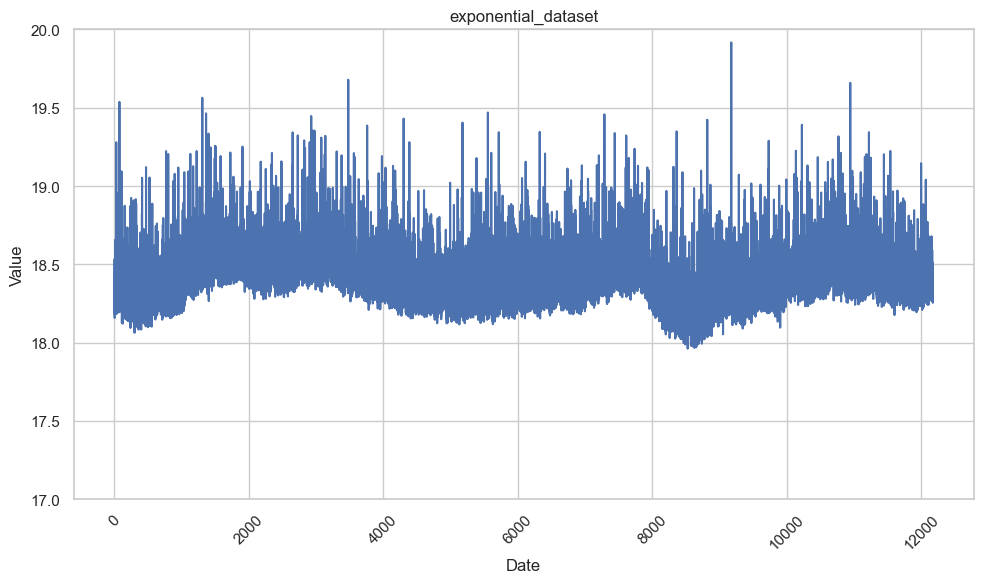

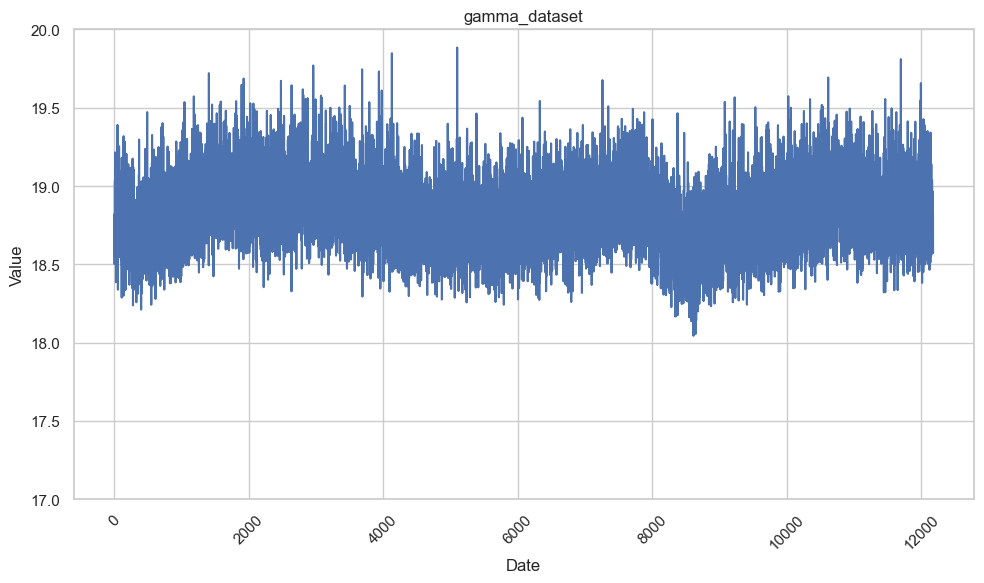

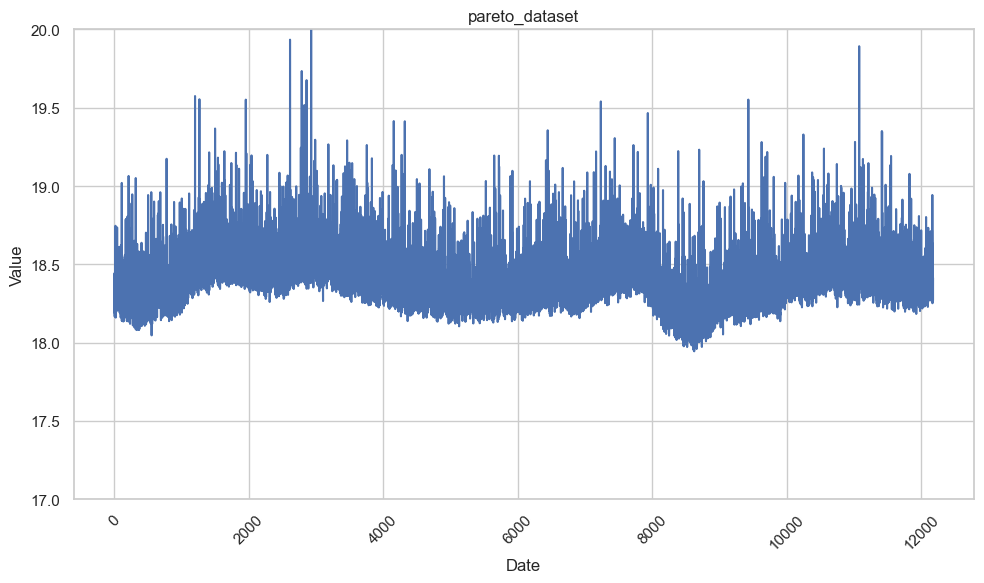

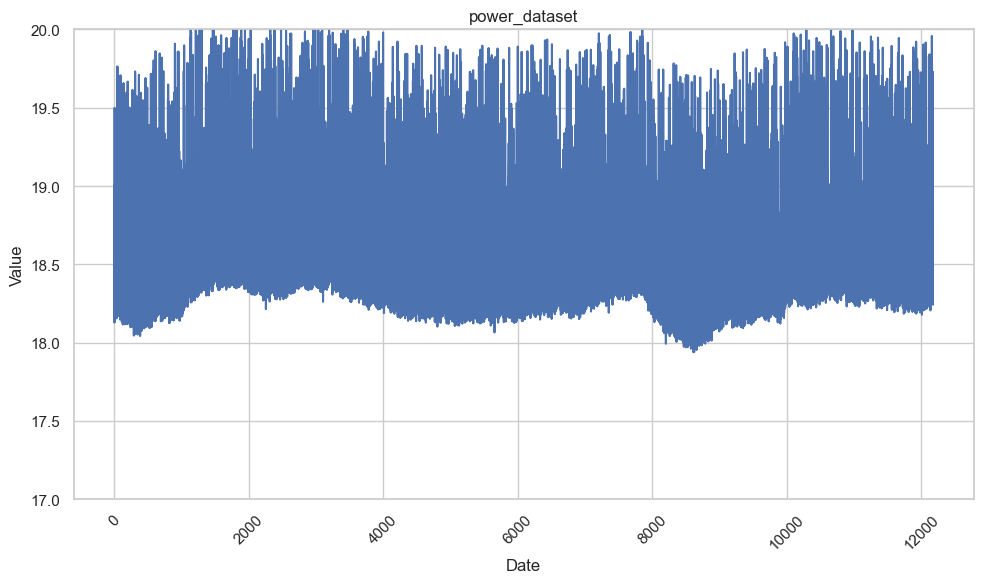

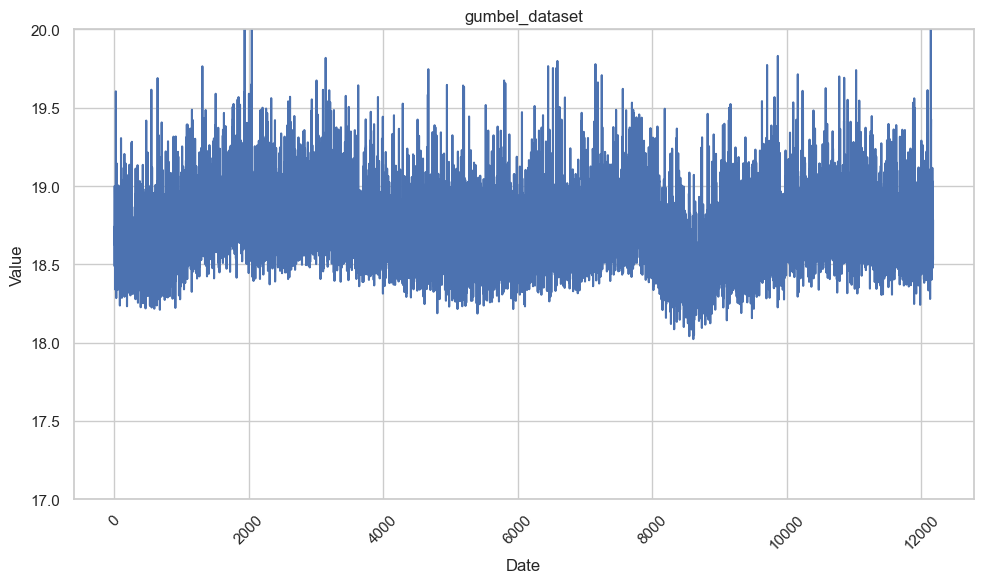

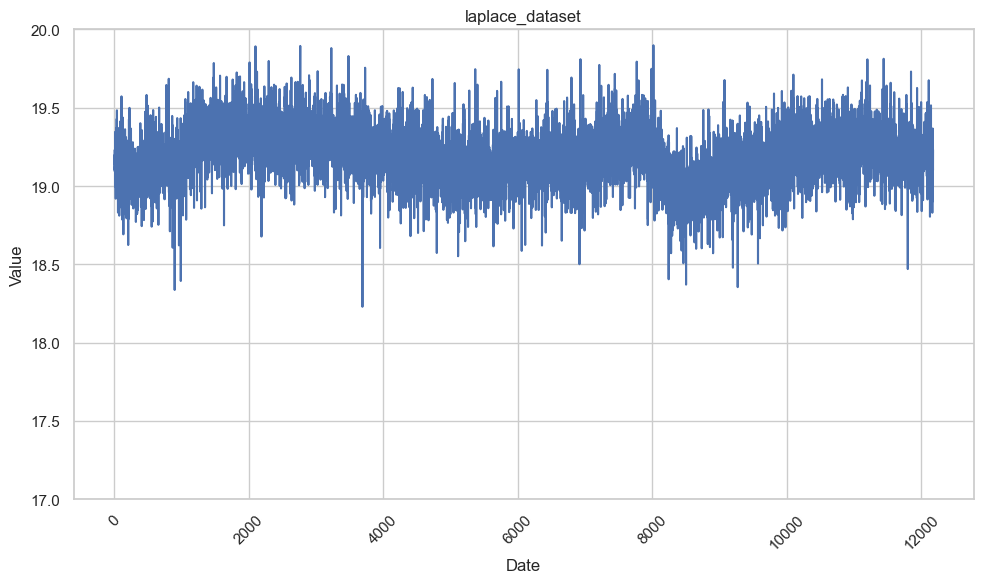

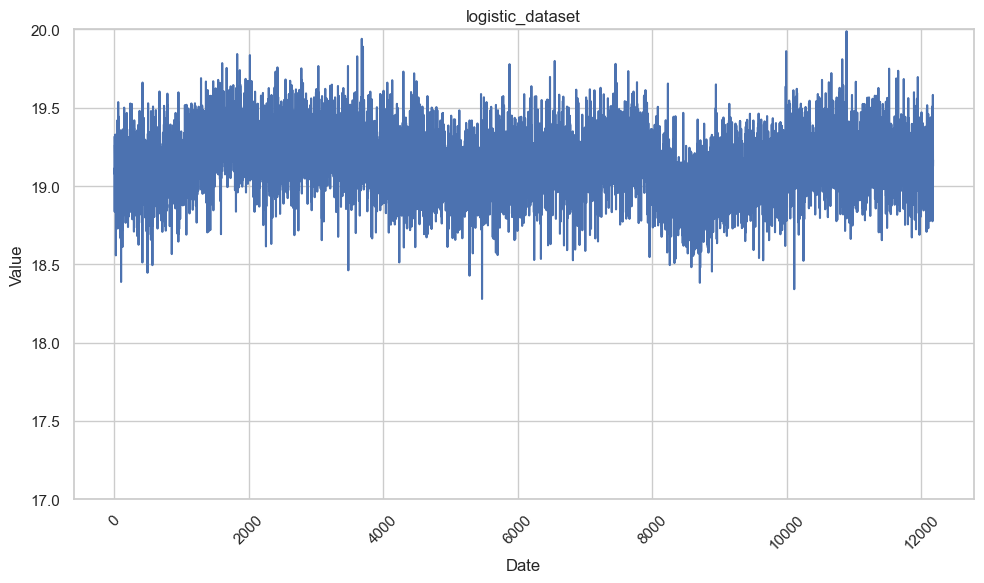

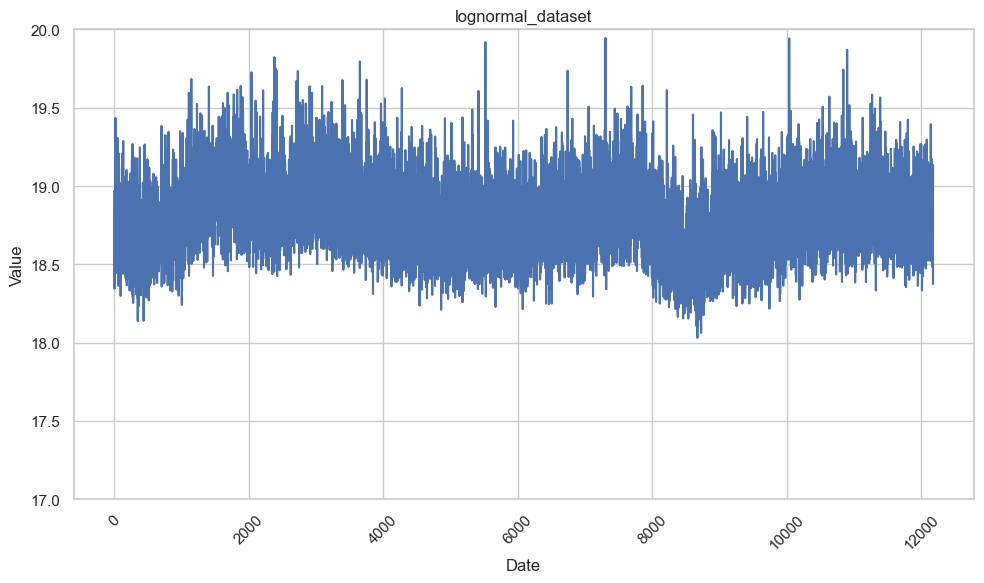

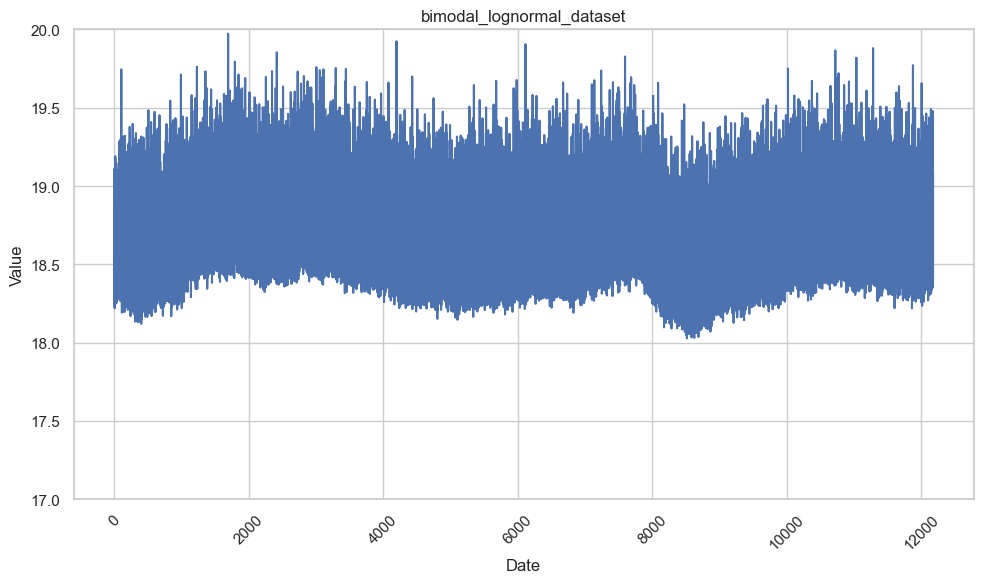

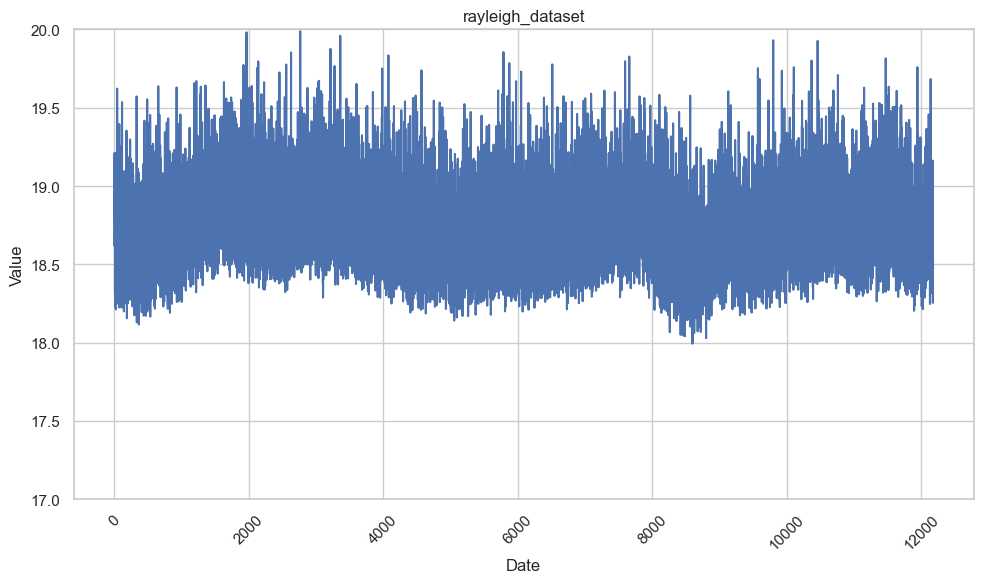

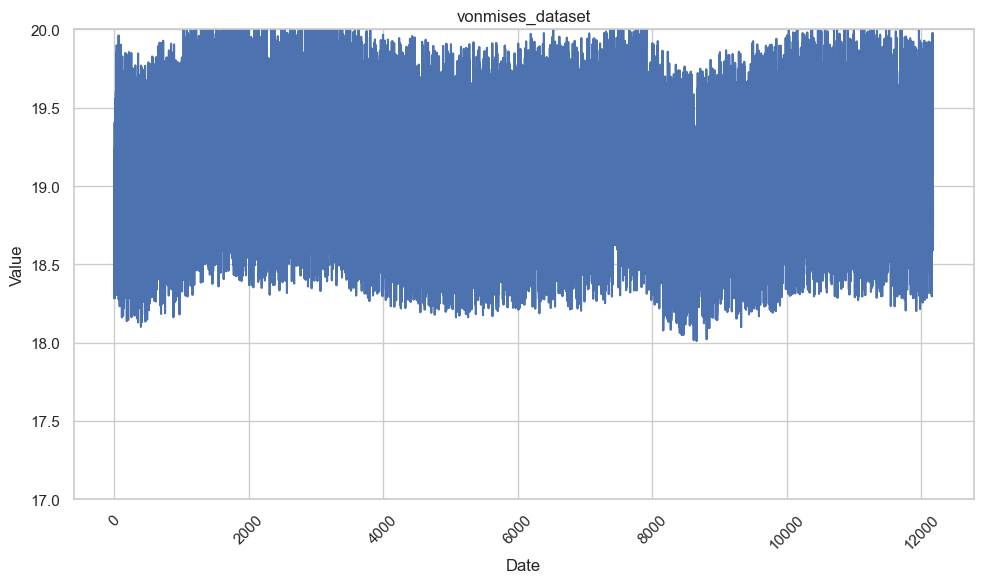

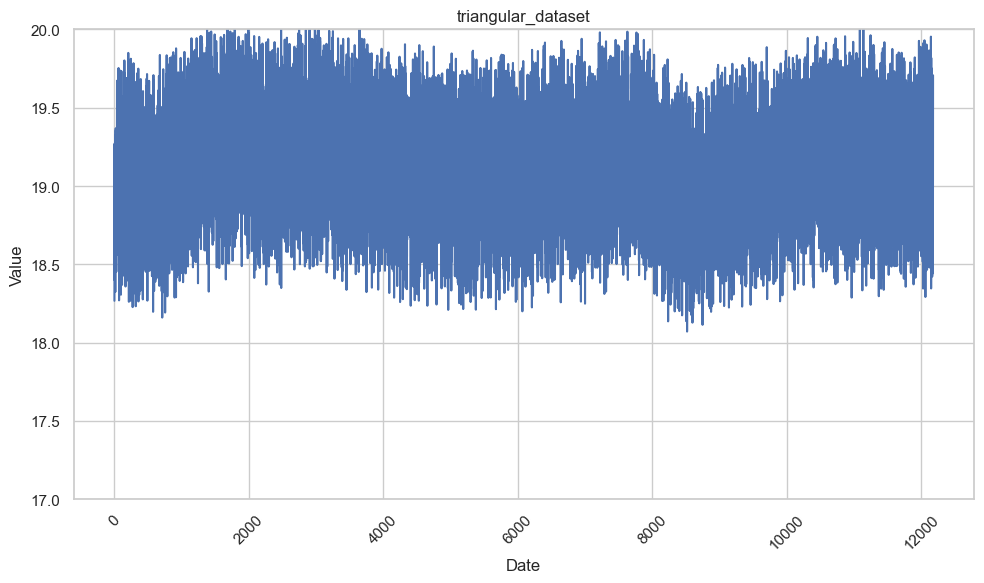

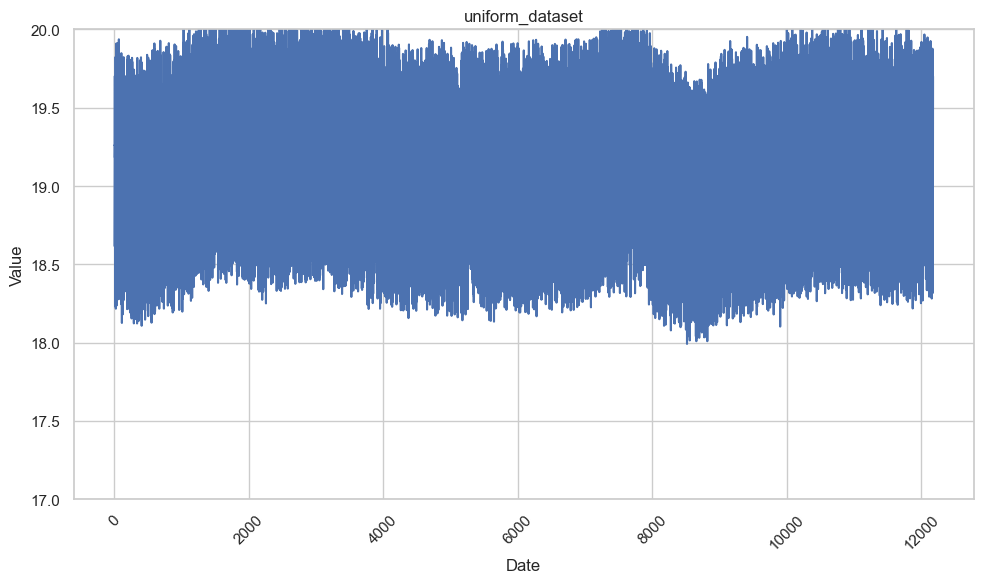

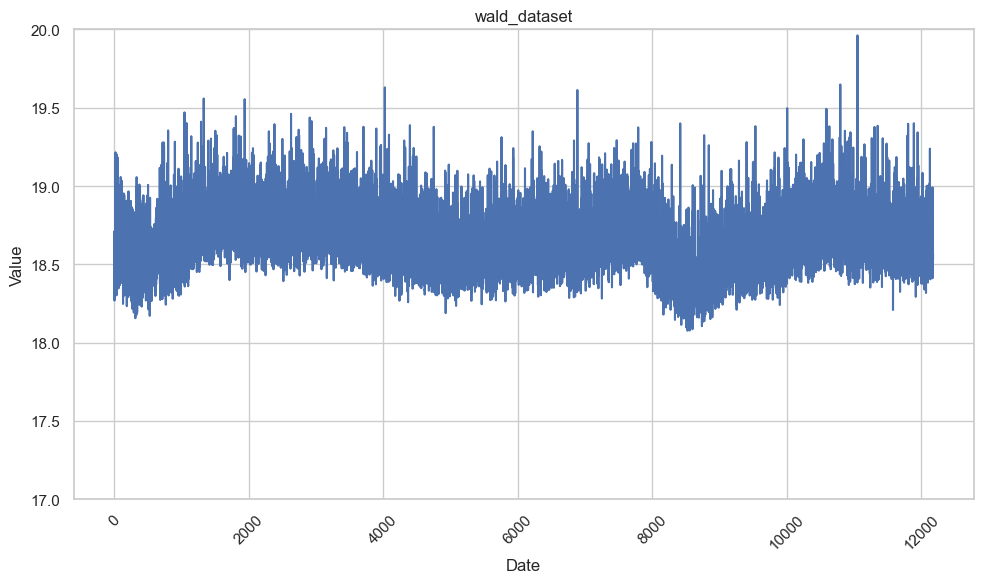

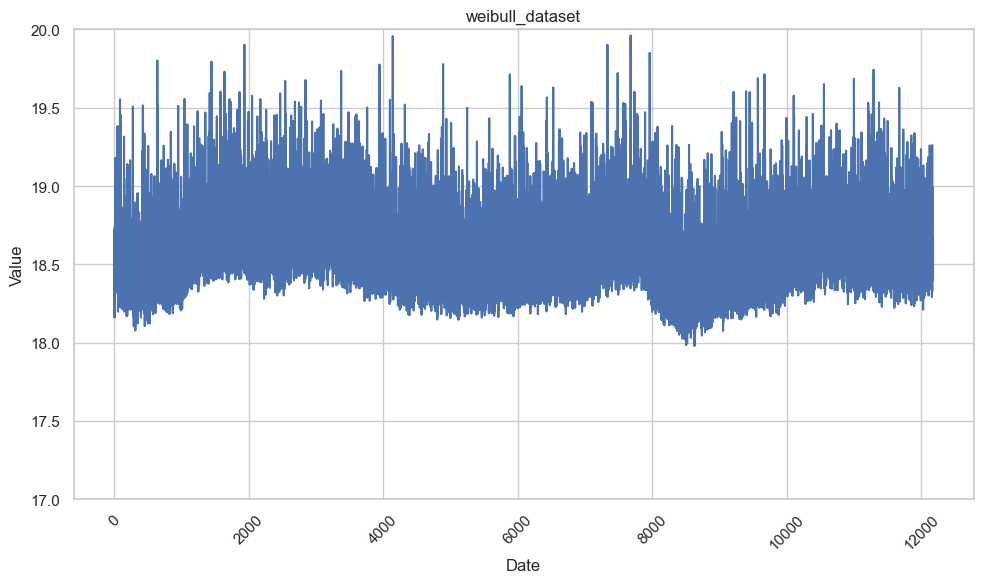

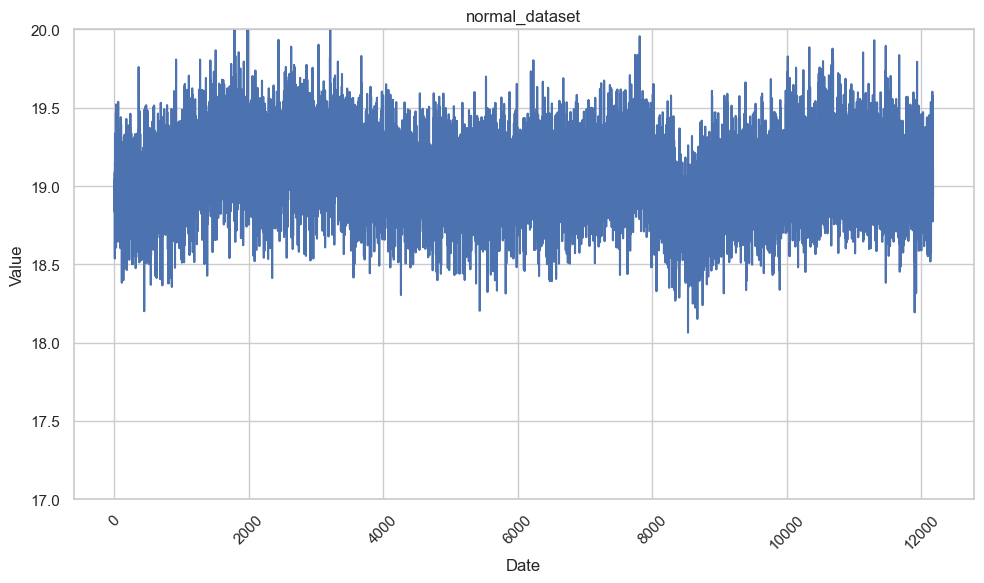

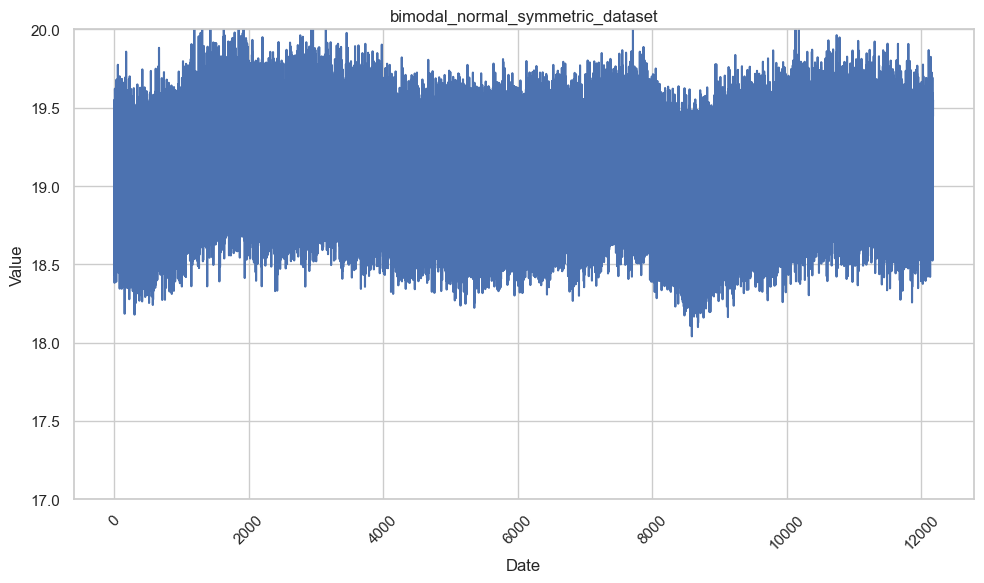

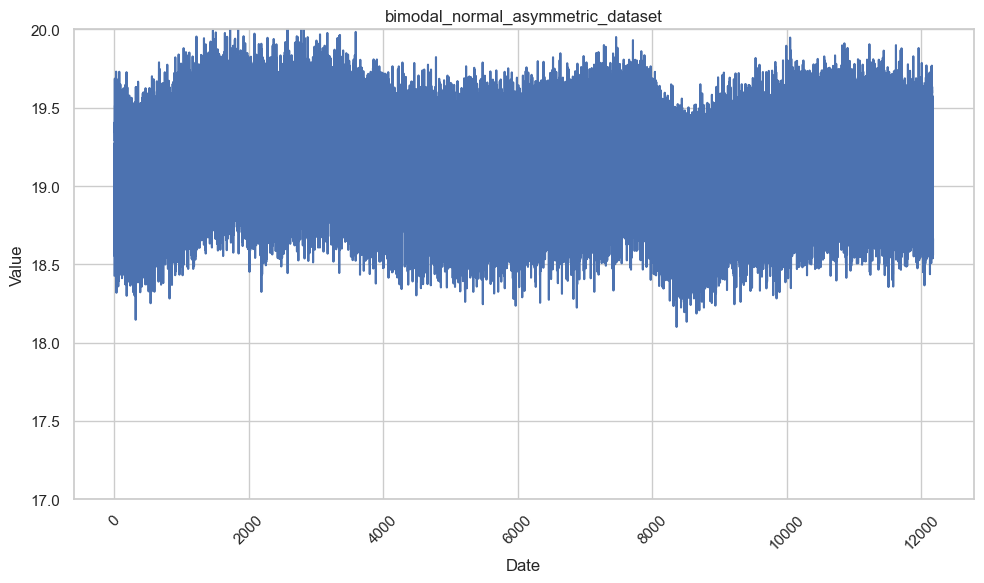

In [132]:
for col in time_series_data.columns:
    plot_time_series(time_series_data[:],col)